# Projet Wi-fi UHA

## Sujet:

### Synopsis
Le projet Wi-Fi UHA consiste à analyser les données relatives à l'enregistrement de la puissance du signal Wi-Fi généré par les points d'accès dans le bâtiment C. 

### Données
Les données obtenus à partir du Fipy Pycomm et ont été sauvegardées dans le dossier *data/raw*. Il contient deux dossiers l'un relatif à une série de mesures effectuées au rez-de-chaussée du bâtiment C, l'autre à une série de mesure au premier étage du bâtiment C. 

### Tâches
Les tâches demandées dans ce projet sont les suivantes.

1. Compléter le programme src/data/extract-data.py afin de formater le jeux de données dans un fichier csv.
2. Écrire un programme qui fusionne deux fichiers csv.
3. Établir pour chaque variable le nombre de valeurs manquantes et aberrante ainsi que le pourcentage que cela représente.
4. Établir le nombre et le pourcentage d'observations qui ont des valeurs aberrantes et/ou manquantes.
5. Définir les fonctions ComputeMean et ComputeMedian (*src/model/model.py*) et calculer la moyenne et la médiane de la puissance du signal Wi-Fi du réseau UHA à chaque emplacement où les mesures ont été effectuées.
6. Afficher la heatmap de la puissance du signal Wi-Fi du réseau UHA en fonction des positions où les mesures ont été effectués


## Installation
**Cloner le repo:**

avec SSH:
```bash
git clone git@github.com:ldsvrn/sae15-wifi.git
```
ou en https:
```bash
git clone https://github.com/ldsvrn/sae15-wifi
```

**Créer l'environnement virtuel:**
```bash
python3 -m venv .venv
source .venv/bin/activate
pip3 install -r requirements.txt
```

**Lancement de Jupyter:**
```bash
.venv/bin/jupyter-notebook
```

**Mise à jour du fichier requirements.txt si nécessaire:**
```bash
pip3 freeze > requirements.txt
```

## Utilisation:
### Parser pour extraire les données brutes:
```bash
src/data/extract-data.py -i *path raw dataset* -o *csv output path*
```
**Code source du script:**
```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import argparse


def ExtractFolderName(path):
    return os.path.dirname(path)


def ExtractFileName(path):
    return os.path.basename(path)


def ExtractPlace(folderName):
    return folderName.split("-")[1]


def ExtractDate(folderName):
    temp = folderName.split("-")[2]
    return f"{temp.split('_')[2]}-{temp.split('_')[1]}-{temp.split('_')[0]}" # ISO8601 date format


def ExtractIdExp(fileName):
    return fileName.split("-")[-1]


def ExtractSsid(content):
    return content.split("'")[0][:-1]


def ExtractMacAddr(content):
    return content.split("'")[1]


def ExtractRssi(content):
    return content.split("'")[2]


def ExtractInfo(path):
    folderName = ExtractFolderName(path)  # Extract folder name
    fileName = ExtractFileName(path)  # Extract filename
    result = ""
    descRd = None
    descRd = open(path, "r")
    content = descRd.readlines()
    for idx in content:
        result += f"{ExtractPlace(folderName)},{ExtractDate(folderName)},{ExtractIdExp(fileName)}," \
                  f"{ExtractSsid(idx)},{ExtractMacAddr(idx)},{ExtractRssi(idx)}"
    descRd.close()
    return result


if __name__ == '__main__':
    # declare variables
    isFileCreated = False
    descWr = None
    result = ""
    folderName = ""
    fileName = ""

    # define arguments
    parser = argparse.ArgumentParser(description='Extract information from Wi-Fi logs')
    parser.add_argument("-i", help="path of the input file", required=True)
    parser.add_argument("-o", help="path of the output file", default="../../data/processed/wifi.csv")
    args = parser.parse_args()

    if os.path.isfile(args.i):
        result = ExtractInfo(args.i)
        descWr = open(args.o, "w")
        descWr.write("Location,Date,ExpId,SSID,Addr,RSSI\n")
        descWr.write(result)
        descWr.close()
    elif os.path.isdir(args.i):
        listFiles = os.listdir(args.i)
        for fichier in listFiles:
            if isFileCreated == False:
                descWr = open(args.o, "w")
                descWr.write("Building,Date,ExpId,SSID,Addr,RSSI\n")
                descWr.close()
                isFileCreated = True
            result = ExtractInfo(args.i + fichier)
            descWr = open(args.o, "a")
            descWr.write(result)
            descWr.close()
            result = ""
    else:
        print("Erreur : le fichier ou le dossier n'existe pas")
```


### Script pour fusionner les csv et trier par ExpId:
```bash
src/data/merge-csv.py -i *csv dataset folder* -o *merged csv*
```
**Code source:**
```python
#!/usr/bin/env python3

import os
import argparse
from glob import glob
import pandas as pd

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Merge and sort csv')
    parser.add_argument("-i", help="path of the input folder", required=True)
    parser.add_argument("-o", help="path of the output file", default="wifi-merged.csv")
    args = parser.parse_args()

    files = glob(os.path.join(args.i, "wifi*.csv"))
    print(files)

    df = pd.concat(map(pd.read_csv, files), ignore_index=True).sort_values(by=["ExpId"], ascending=True)
    df.to_csv(args.o, index=False)

```

## Nettoyage et tri des données

On commence par importer la library clean (le fichier est simlink de scr/data/clean.py à notebook/clean.py pour être importé)

In [1]:
import clean

Ensuite, on crée l'objet en précisant l'emplacement du csv, les réseaux que l'on souhaite analyser (liste séparée par des virgules) et éventuellement supprimer les doublons.

On peut ensuite lancer le nettoyage et le tri avec la méthode `clean()`

In [2]:
cleaner = clean.Cleaner("../data/processed/wifi-merged.csv", "uha")

# On récupère le nombres de lignes avant de nettoyer
totalLines = cleaner.get_lines()

# On peut nettoyer et trier:
cleaner.clean()

Grâce à la méthode `get_delete_reason()`, on récupère un dictonnaire décrivant combien de lignes ont été supprimées pour chaque raison.

- **"null"** pour les lignes comportant une cellule vide
- **"duplicates"** pour le lignes doublons (seulement si la suppression est activée)
- **"RSSI"** pour les valeurs de RSSI aberrantes (pas entre -100 et -10, les limites du 802.11)
- **"SSID"** pour les valeurs d'autres réseaux que ceux précisés

In [3]:
cleaner.get_delete_reason()

# On la stocke dans une variable pour réutiliser les données facilement
delete_reason = cleaner.get_delete_reason()

Parmis les valeurs supprimées:
- 1 on été supprimé pour null (soit 0.024%)
- 4 on été supprimé pour RSSI (soit 0.096%)
- 4142 on été supprimé pour SSID (soit 99.879%)


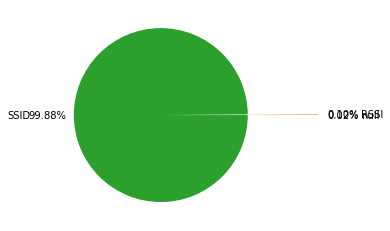

In [6]:
import matplotlib.pyplot as plt
import numpy as np

after_delete = cleaner.get_lines()
total_deleted= cleaner.get_total_deleted()

chart_val = []
chart_label = []

print("Parmis les valeurs supprimées:")
for i in delete_reason:
    print(f"- {delete_reason[i]} on été supprimé pour {i} (soit {round(delete_reason[i]/total_deleted*100, 3)}%)")
    chart_val.append(delete_reason[i])
    chart_label.append(i)
    

plt.pie(chart_val, labels = chart_label, explode=cleaner.get_explode_val(), pctdistance=1.3, labeldistance=1.5, autopct='%1.2f%%')
plt.show()